# Numerical Fourier Transforms

In [1]:
from __future__ import print_function
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In this exercise we'll explore how one can take Fourier transforms numerically using Python. Recall that the Discrete Fourier Transform (DFT) of a discrete set of points $g_1 = g(t_1)$, $g_2 = g(t_2) $, ..., $g_N = g(t_N = T)$ is defined to be

$\tilde{g}_n \equiv \sum_{m=1}^N g_m \exp \left( \frac{-i 2 \pi m n }{N} \right)$

which tells us how much of each complex exponential is needed to reconstruct the series of $g_m$ values. This reconstruction is accomplished by the inverse Discrete Fourier transform, given by

$g_m \equiv \frac{1}{N} \sum_{n=1}^N \tilde{g}_n \exp \left( \frac{+i 2 \pi m n }{N} \right)$.

Python has built-in functions to compute Fourier transforms. They can be found under `np.fft`, where "FFT" stands for "Fast Fourier Transform". The FFT is mathematically the same as the DFT, but uses various internal computing tricks to make things "fast". Let's try it out!

## Tophat Example

The tophat function is a function is a function that is $1$ close to the origin but zero everywhere else.

In [2]:
def tophat(t,a):
    out = t.copy()
    for i,elem in enumerate(t):
        if abs(elem) > a:
            out[i] = 0.
        else:
            out[i] = 1.
    return out

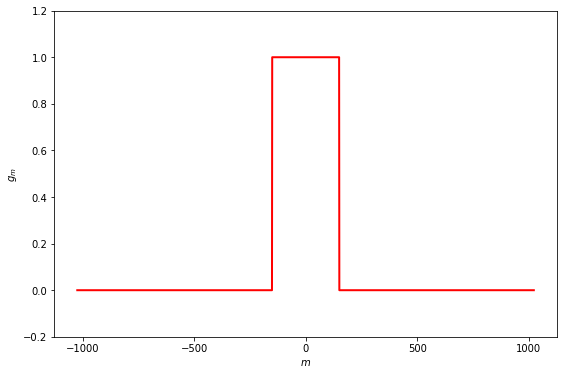

In [4]:
m_coords = np.arange(-1024, 1024)
gt = tophat(m_coords,150)

f, ax = plt.subplots(figsize=(9,6))
ax.plot(m_coords,gt,lw=2,c='red')
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$g_m$")
ax.set_ylim(-0.2, 1.2)
plt.show()

Here, you'll see that rather than having $m$ start at zero, I decided to have it be centered around zero, so that the $g_m$'s start from $m= -N/2$ rather than $m=0$. This is typical of a lot of our data. However, the slightly irritating thing about most numerical FFT routines is that they assume we're starting at $m=0$ Luckily, `numpy` provides a handy routine called "fftshift" that can be used to put our data into the right format.

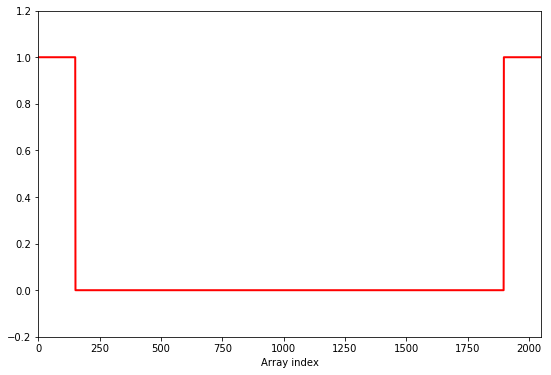

In [6]:
f, ax = plt.subplots(figsize=(9,6))
ax.plot(np.fft.fftshift(gt),lw=2,c='red')
ax.set_xlim(0,2048)
ax.set_ylim(-0.2,1.2)
ax.set_xlabel("Array index")
plt.show()

Indeed, the first element of the array now corresponds to $g_0$. But notice how the part of the function immediately to the left of $m=0$ is now on the far right! It turns out that FFTs assume that axes "wrap around". So in our new ordering scheme, the data goes from $m=0$ to $m=-N/2$, and then goes from $t=-N/2$ back up to $t=0$. Thus, the left half of the bump at appears on the far right. Said differently, FFTs assume that our function is periodic. In this way, FFTs are actually quite closely related to Fourier *Series* (which, remember, are for like Fourier transforms for periodic functions).

The FFT algorithm also orders the *output* of the FFT with $\tilde{g}_0$ as the first element. Thus, the output needs to be adjusted too, and the whole process is given by an initial np.fft.fftshift, the actual FFT using np.fft.fft, and the reordering of the final result using another np.fft.fftshift:

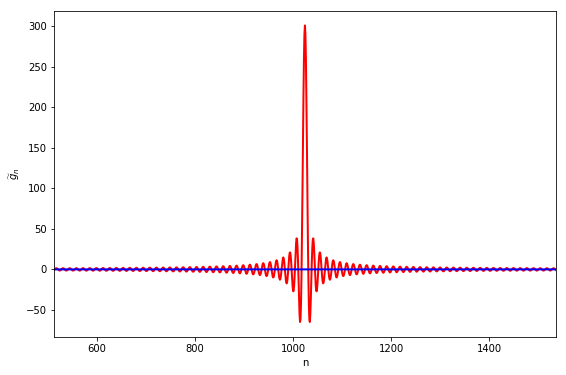

In [11]:
gtilde = np.fft.fftshift(np.fft.fft(np.fft.fftshift(gt)))

f, ax = plt.subplots(figsize=(9,6))
ax.plot(gtilde.real,lw=2,c='red')
ax.plot(gtilde.imag,lw=2,c='blue')
ax.set_xlim(512,1536)
ax.set_xlabel("n")
ax.set_ylabel(r"$\widetilde{g}_n$")
plt.show()

This is known as a <b> sinc </b> function.  What happens because of the symmetry of the original function? 

This looks like the function $\tilde{g} (f) = \sin (2 \pi f) / \pi f$ that we would've predicted by doing the analytic version of the Fourier transform. But whereas the pencil-and-paper version gave us a continuous function of $f$, here we have a bunch of values in an array, and we need to know which value of $f$ each element of the output array corresonds to. It turns out that numpy has a function called np.fft.fftfreq for this. As input, it needs to know the length of the original input array to the FFT, as well as the spacing in $f$ that is assumed there.

## The Fourier transform of a Gaussian

The Gaussian function is given by

$g(m) = \frac{1}{\sqrt{2 \pi a^2}}\exp \left[-\frac{(m-b)^2}{2 a^2}\right]$,

and is charaterized by two parameters, the location $b$ of its peak, and its width $a$ (rigorously, this width is defined as the standard deviation of the curve). Because of the way Gaussians look, they're often also known as Bell curves:

In [9]:
def gauss(t,a,b):
    exponent = -(t-b)**2
    exponent /= 2*a**2
    return np.exp(exponent)/np.sqrt(2.*np.pi*a**2)

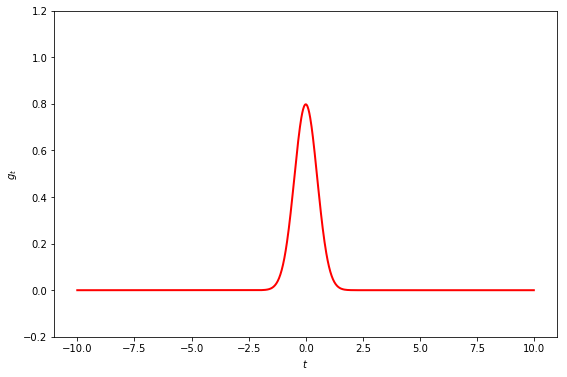

In [13]:
t_coords = np.linspace(-10.,10.,1025)[:-1]

f, ax = plt.subplots(figsize=(9,6))
ax.plot(t_coords,gauss(t_coords,0.5,0.),lw=2,c='red')
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$g_t$")
ax.set_ylim(-0.2, 1.2)
plt.show()

<b> Q1. What is the Fourier transform of a Gaussian that is centered on the origin?

<b> Solution:

<b> Q2. If one compresses $g(t)$ horizontally by some factor, what happens to its Fourier transform $\tilde{g} (f)$?

<b> Solution:

## Implementing filters using Fourier transforms

One of the most important applications of Fourier transforms is to allow us to filter data. As an example, we will filter some audio clips. First, we need to load some packages to allow us to record and play back audio.

https://python-sounddevice.readthedocs.io/en/0.3.12/installation.html

To install:
`conda install -c conda-forge python-sounddevice`

In [14]:
import sounddevice as sd
fs = 48000

def record_clip(duration):
    myrecording = sd.rec(int(duration * fs), samplerate=fs, channels=1, blocking=True, dtype='float64')
    return myrecording.flatten()

Let's first listen to a pre-recorded clip:

In [15]:
evil_laugh = np.load("evil_laugh.npy")
sd.play(evil_laugh)

Plotting the waveform of the sound clip gives

Text(0.5, 0, 'Sample number')

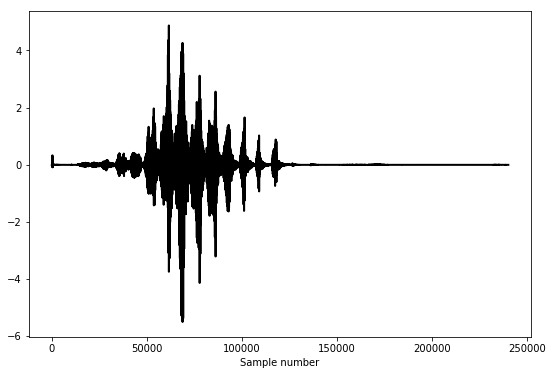

In [16]:
f, ax = plt.subplots(figsize=(9,6))
ax.plot(evil_laugh,lw=2,c='black')
# ax.set_ylabel(r"$f$")
ax.set_xlabel("Sample number")

Zooming into a smaller portion gives us a better view

Text(0.5, 0, 'Sample number')

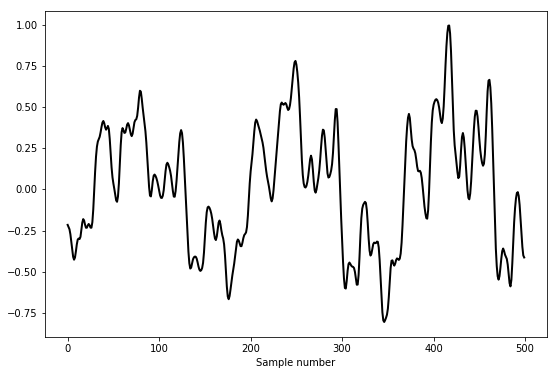

In [17]:
f, ax = plt.subplots(figsize=(9,6))
ax.plot(evil_laugh[50000:50500],lw=2,c='black')
# ax.set_ylabel(r"$f$")
ax.set_xlabel("Sample number")

Clearly, the sound wave is comprised of a lot of different bumps and wiggles that have different periodicities. Equivalently, we might say that this function is comprised of lots of different waves of different frequencies, which for sound waves, corresponds to different pitches. Fourier analysis allows us to look at precisely what mix of different frequency waves came together to give this sound clip.

In [18]:
evil_fourier = np.fft.fftshift(np.fft.fft(np.fft.fftshift(evil_laugh)))
freq_coords = np.fft.fftshift(np.fft.fftfreq(len(evil_laugh),d=1./fs))

Note that this sound clip was recorded with fs$=48000$ samples per second, so in the line above, we told the fftshift function that the time between adjacent time samples was $1/$fs. The resulting coordinates of the Fourier transform (stored in freq_coords) are in Hz. The real part of the Fourier transform is shown below:

Text(0.5, 0, 'Frequency in Hz')

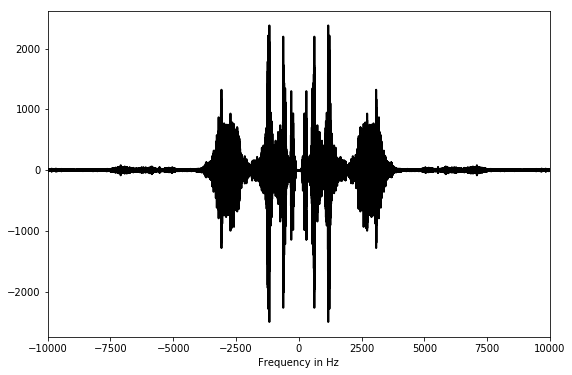

In [19]:
f, ax = plt.subplots(figsize=(9,6))
ax.plot(freq_coords,evil_fourier.real,lw=2,c='black')
ax.set_xlim(-10000,10000)
ax.set_xlabel(r"Frequency in Hz")

One sees that the laugh has some prominent low frequency (low pitch) components up to about $2000\,{\rm Hz}$, and then another "blob" of higher frequency (higher pitch) components, but doesn't have much beyond that. (Incidentally, why are there *negative* frequency components?!)

Having examined our sound clip in "the frequency domain", we could perform an inverse Fourier transform to view the signal back in "the time domain". The resulting signal would be precisely the same function that we began with. A more interesting thing to do would be to filter the data. For instance, we could artifically block off the low frequency components, and then do the inverse Fourier transform. Let's try that and see what it sounds like.

In [20]:
evil_fourier_hi = np.zeros_like(evil_fourier)
for i,(fourier_comp, freq) in enumerate(zip(evil_fourier,freq_coords)):
    if abs(freq) > 2000.:
        evil_fourier_hi[i] = fourier_comp

Text(0.5, 0, 'Frequency in Hz')

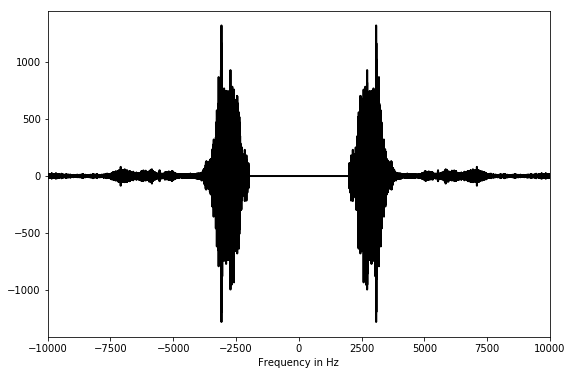

In [21]:
f, ax = plt.subplots(figsize=(9,6))
ax.plot(freq_coords,evil_fourier_hi.real,lw=2,c='black')
ax.set_xlim(-10000,10000)
ax.set_xlabel(r"Frequency in Hz")

We've filtered the low-frequency components (lower than $2000\,{\rm Hz}$) out; the resulting signal is said to have been "high-pass filtered", because we have allowed the high frequency components to pass through. Let's take an inverse FFT back to the time domain, where we can play the sound clip to see what it sounds like.

In [22]:
evil_laugh_hi = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(evil_fourier_hi)))

Before we play the sound, though, here's a helpful check. The sound wave ought to consist only of real numbers. If not, we've been careless about how we've implemented our filter. We'll explore this more carefully in the next set of notebook exercises, but if you want a hint/preview, it's related to the question we asked earlier about negative frequencies. Printing out the first ten elements of our filtered soundwave, we get

In [23]:
print(evil_laugh_hi[:10])

[ 0.00224553+3.22929915e-17j  0.00236062-1.30570055e-17j
  0.00231573-3.38762661e-17j  0.00211285+1.62030797e-17j
  0.00176484-3.75940989e-17j  0.00129459-1.05578204e-17j
  0.00073354+2.82252247e-17j  0.00011956-1.15154858e-18j
 -0.00050562-1.58767358e-17j -0.00109922+3.75341160e-17j]


The imaginary components are about $16$ orders of magnitude down from the real parts. This is well within numerical roundoff error, so let's just take the real part of this and call it a day.

In [24]:
evil_laugh_hi = evil_laugh_hi.real

In [25]:
sd.play(evil_laugh_hi)

Compare this to the original clip!

In [26]:
sd.play(evil_laugh)

Having filtered out the low frequencies (low pitches), the sound clip has lost some of its bass richness. Instead of a high-pass filter, we could instead implement a low-pass filter.

In [27]:
evil_fourier_lo = np.zeros_like(evil_fourier)
for i,(fourier_comp, freq) in enumerate(zip(evil_fourier,freq_coords)):
    if abs(freq) < 2000.:
        evil_fourier_lo[i] = fourier_comp

In [28]:
evil_laugh_lo = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(evil_fourier_lo)))

In [29]:
evil_laugh_lo = evil_laugh_lo.real

In [30]:
sd.play(evil_laugh_lo)

Now we have the bass, but it sounds more muffled than before because we've lost the crisp treble components.

Incidentally, recall that when we were learning Fourier series, we sometimes truncated the series. We'd take a function, figure out the coefficients of the first few sines and cosines, and then only add together the first few terms in the series (after all, there are an infinite terms to add up!) This was really just a low-pass filter, because by omitting the later terms in the Fourier series, we didn't include the highest frequency (shortest period) sines and cosines. If you look back at some of the results, you'll see that our low-pass approximations weren't able to get the finest, sharpest features (like the corners in the triangle or square waves), just as our low-pass filtered sound clip doesn't have the crispiest treble components.

## Have fun with your own voice!

Take a few minutes to have some fun recording and filtering your own voice! To record a sound clip, use the record_clip function defined above, which takes the length of your intended recording (in seconds) as input. For example, 

my_recording = record_clip(10.0)

will record for $10\,{\rm s}$ and put the resulting data into an array called my_recording.

Experiment will filtering your own voice, or compare your voice with your friend's voice in the frequency domain!

In [ ]:
my_recording = record_clip(10.0)

In [ ]:
sd.play(my_recording)